In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

Mixture models

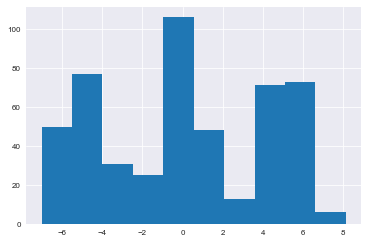

In [2]:
import pymc3 as pm, theano.tensor as tt
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [3]:
centers

array([-5,  0,  5])

In [8]:
v[1:15]

array([1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2])

In [7]:
centers[v][1:15]

array([ 0,  0,  0, -5,  0,  5,  5,  0,  5,  0,  0,  5,  0,  5])

In [9]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [10]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

/Users/hbi16859/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd_interval__]
>>Metropolis: [p_stickbreaking__]
>ElemwiseCategorical: [category]
100%|██████████| 10500/10500 [01:28<00:00, 118.96it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ec97f60>,
      dtype=object)

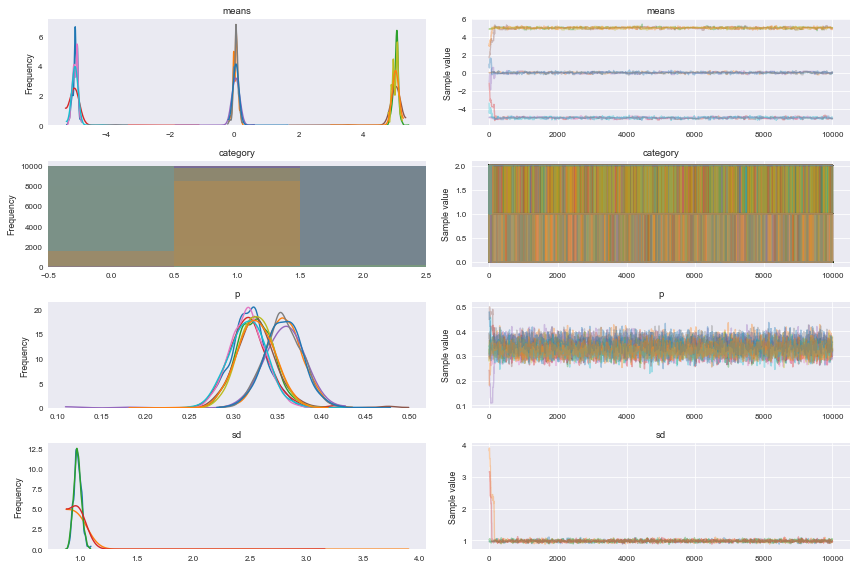

In [11]:
pm.traceplot(tr)

Compound steps
When sampling a model with multiple free random variables, the compound steps will be needed in the pm.sample function. When the compound steps are involved, the function takes a list of step to generate a list of methods for different random variables. So for example in the following code,

In [12]:
import theano
n_ = theano.shared(np.asarray([10, 15]))
with pm.Model() as m:
    p = pm.Beta('p', 1., 1.)
    ni = pm.Bernoulli('ni', .5)
    k = pm.Binomial('k', p=p, n=n_[ni], observed=4)
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_logodds__]
>BinaryGibbsMetropolis: [ni]
100%|██████████| 1000/1000 [00:00<00:00, 1465.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d5bb2e8>,
      dtype=object)

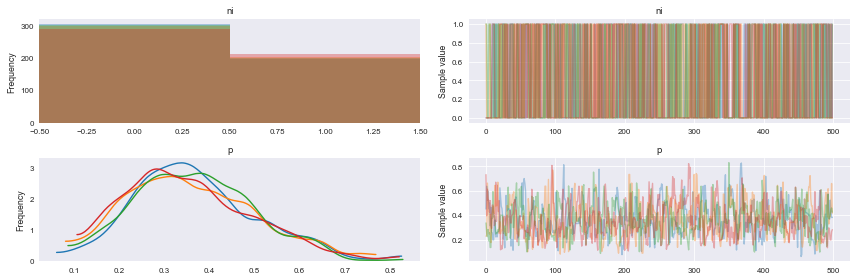

In [13]:
pm.traceplot(trace)

There are two free parameters in the model we would like to sample from, a continuous variable p_logodds__ and a binary variable ni.

When we call pm.sample(), PyMC3 assigns the best step method to each of them. For example, NUTS was assigned to p_logodds__ and BinaryGibbsMetropolis was assigned to ni.

In [15]:
#But we can also specify the steps manually:
with m:
    step1 = pm.Metropolis([p])
    step2 = pm.BinaryGibbsMetropolis([ni])
    trace_compound=pm.sample(300,steps=[step1,step2])

Only 300 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_logodds__]
>BinaryGibbsMetropolis: [ni]
100%|██████████| 800/800 [00:00<00:00, 1469.71it/s]
The acceptance probability does not match the target. It is 0.8862993352880295, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c3eabe0>,
      dtype=object)

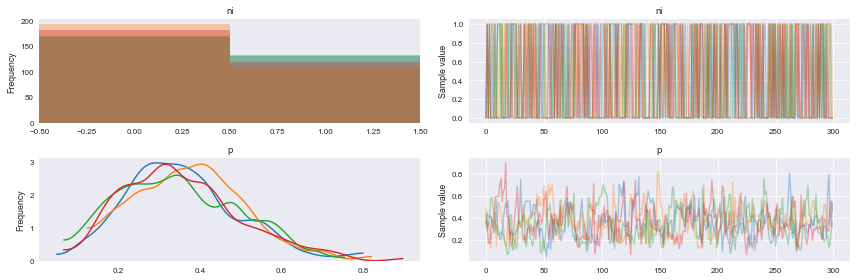

In [17]:
pm.traceplot(trace_compound)

In [18]:
pm.summary(trace_compound)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ni,0.408333,0.491525,0.014743,0.000000,1.000000,834.250519,1.001318
p,0.358276,0.141335,0.007079,0.107104,0.621215,334.142863,1.002030


Order of step methods
When in the default setting, the parameter update order follows the same order of the random variables, and it is assigned automatically. But if you specify the steps, you can change the order of the methods in the list: